## Knowledge extraction for Experiment 2

In [2]:
import h5py

with h5py.File('./data/magnetic/kuka_dir-rnd_1500k_n10_v2_f10.h5', 'r') as hf:
    kuka_fwd = hf['kuka_magnetic_fwd'][()]
    kuka_inv = hf['kuka_magnetic_inv'][()]

In [3]:
# assert len(obj_xyz_0) == 3
# assert len(obj_rot_0) == 4
# assert len(color) == 3
# assert len(joints_0) == n_joints
# assert len(eff_xyz_0) == 3
# assert len(eff_rot_0) == 4

import numpy as np
from sklearn.preprocessing import normalize

X_fwd, y_fwd = np.hsplit(kuka_fwd, [33])

(
    X_fwd_obj_xyz, X_fwd_obj_rot, X_fwd_color,
    X_fwd_joints, X_fwd_eff_xyz, X_fwd_eff_rot, X_fwd_magnet,
    X_fwd_action
) = np.hsplit(X_fwd, [3, 7, 10, 17, 20, 24, 25])

X_fwd_obj_rot_axis = normalize(X_fwd_obj_rot[:, :3], norm='l2')
X_fwd_eff_rot_axis = normalize(X_fwd_eff_rot[:, :3], norm='l2')

X_fwd_axis = np.hstack([
    X_fwd_obj_xyz, X_fwd_obj_rot_axis, X_fwd_color,
    X_fwd_joints, X_fwd_eff_xyz, X_fwd_eff_rot_axis, X_fwd_magnet,
    X_fwd_action
])

(
    y_fwd_obj_xyz, y_fwd_obj_rot, y_fwd_color,
    y_fwd_joints, y_fwd_eff_xyz, y_fwd_eff_rot, y_fwd_magnet
) = np.hsplit(y_fwd, [3, 7, 10, 17, 20, 24])

y_fwd_obj_rot_axis = normalize(y_fwd_obj_rot[:, :3], norm='l2')
y_fwd_eff_rot_axis = normalize(y_fwd_eff_rot[:, :3], norm='l2')

y_fwd_axis = np.hstack([
    y_fwd_obj_xyz, y_fwd_obj_rot_axis, y_fwd_color,
    y_fwd_joints, y_fwd_eff_xyz, y_fwd_eff_rot_axis, y_fwd_magnet
])

X_inv, y_inv = np.hsplit(kuka_inv, [50])
(
    # S0
    X_inv_obj_xyz_0, X_inv_obj_rot_0, X_inv_color_0,
    X_inv_joints_0, X_inv_eff_xyz_0, X_inv_eff_rot_0, X_inv_magnet_0,

    # S1
    X_inv_obj_xyz_1, X_inv_obj_rot_1, X_inv_color_1,
    X_inv_joints_1, X_inv_eff_xyz_1, X_inv_eff_rot_1, X_inv_magnet_1
) = np.hsplit(
    X_inv,
    [
        3, 7, 10, 17, 20, 24, 25,  # S0 
        28, 32, 35, 42, 45, 49  # S1
    ]
)

X_inv_obj_rot_0_axis = normalize(X_inv_obj_rot_0[:, :3], norm='l2')
X_inv_eff_rot_0_axis = normalize(X_inv_eff_rot_0[:, :3], norm='l2')
X_inv_obj_rot_1_axis = normalize(X_inv_obj_rot_1[:, :3], norm='l2')
X_inv_eff_rot_1_axis = normalize(X_inv_eff_rot_1[:, :3], norm='l2')

X_inv_reduced = np.hstack([
    X_inv_obj_xyz_0, X_inv_obj_rot_0_axis, X_inv_color_0,
    X_inv_joints_0, X_inv_eff_xyz_0, X_inv_eff_rot_0_axis, X_inv_magnet_0,

    X_inv_obj_xyz_1, X_inv_obj_rot_1_axis, X_inv_color_1,
    X_inv_eff_xyz_1, X_inv_eff_rot_1_axis, X_inv_magnet_1
])

In [4]:
from sklearn.model_selection import train_test_split

X_fwd_shap_train, X_fwd_shap_test, y_fwd_shap_train, y_fwd_shap_test = train_test_split(
    X_fwd_axis, y_fwd_axis,
    train_size=100_000,
    test_size=20_000,
    random_state=42,
    shuffle=True
)

In [5]:
from keras.models import load_model

fwd_model = load_model('models/magnetic/kuka_fwd_45ep.keras')
inv_model = load_model('models/magnetic/kuka_inv.keras')

2024-03-24 20:13:43.525749: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 20:13:44.038273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 20:13:44.038443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 20:13:44.107449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 20:13:44.269669: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 20:13:44.272011: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
import shap

shap.initjs()

In [7]:
X_fwd_sampled = shap.sample(X_fwd_shap_train, 200)
# X_fwd_simplified = shap.kmeans(X_fwd_sampled, 300)

In [9]:
from keras.layers import Concatenate, Input
from keras.models import Model

fwd_model.trainable = False

inp = Input(shape=(31,))
fwd_out = fwd_model(inp, training=False)

fwd_concat = Concatenate()(fwd_out)

fwd_concat_model = Model(
    inputs=inp,
    outputs=fwd_concat,
    name='fwd_concat'
)

fwd_concat_model.compile(
    optimizer='adam',
    loss='mse'
)

fwd_concat_model.summary(expand_nested=True, show_trainable=True)

Model: "fwd_concat"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_2 (InputLayer)        [(None, 31)]                 0         []                            Y          
                                                                                                             
 fwd_model (Functional)      [(None, 3),                  9223      ['input_2[0][0]']             N          
                              (None, 3),                                                                     
                              (None, 3),                                                                     
                              (None, 7),                                                                     
                              (None, 3),                                                            

In [10]:
d_explainer = shap.DeepExplainer(
    model=(inp, fwd_concat),
    data=shap.sample(X_fwd_shap_train, 10_000)
)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [11]:
d_exps = d_explainer.shap_values(X=shap.sample(X_fwd_shap_test, nsamples=200))

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


KeyboardInterrupt: 

In [2]:
import dill

with open('../../data/magnetic/kuka_magnetic_deep_exps.pkl', 'rb') as f:
    exp_file = dill.load(f)

In [3]:
d_exps = exp_file['exps']

In [4]:
import numpy as np

d_exps = np.moveaxis(d_exps, 2, 0)

In [14]:
x_labels = [
    'obj_X_0', 'obj_Y_0', 'obj_Z_0', 'obj_RX_0', 'obj_RY_0', 'obj_RZ_0',
    'color_R_0', 'color_G_0', 'color_B_0',
    'joint_0_0', 'joint_1_0', 'joint_2_0', 'joint_3_0', 'joint_4_0', 'joint_5_0', 'joint_6_0',
    'eff_X_0', 'eff_Y_0', 'eff_Z_0', 'eff_RX_0', 'eff_RY_0', 'eff_RZ_0', 'magnet_state_0',
    'act_0_0', 'act_1_0', 'act_2_0', 'act_3_0', 'act_4_0', 'act_5_0', 'act_6_0', 'act_magnet_0'
]

y_labels = [
    'obj_X_1', 'obj_Y_1', 'obj_Z_1', 'obj_RX_1', 'obj_RY_1', 'obj_RZ_1',
    'color_R_1', 'color_G_1', 'color_B_1',
    'joint_0_1', 'joint_1_1', 'joint_2_1', 'joint_3_1', 'joint_4_1', 'joint_5_1', 'joint_6_1',
    'eff_X_1', 'eff_Y_1', 'eff_Z_1', 'eff_RX_1', 'eff_RY_1', 'eff_RZ_1', 'magnet_state_1'
]

x_labels_tex = [
    r'$o(t)_x$', r'$o(t)_y$', r'$o(t)_z$', r'$o(t)_{\it rx}$', r'$o(t)_{\it ry}$', r'$o(t)_{\it rz}$',
    r'$o(t)_R$', r'$o(t)_G$', r'$o(t)_B$',
    r'$\theta(t)_0$', r'$\theta(t)_1$', r'$\theta(t)_2$', r'$\theta(t)_3$', r'$\theta(t)_4$', r'$\theta(t)_5$', r'$\theta(t)_6$',
    r'${\it ef}(t)_x$', r'${\it ef}(t)_y$', r'${\it ef}(t)_z$', r'${\it ef}(t)_{\it rx}$', r'${\it ef}(t)_{\it ry}$', r'${\it ef}(t)_{\it rz}$', r'${\it mgt}(t)$',
    r'$a(t)_0$', r'$a(t)_1$', r'$a(t)_2$', r'$a(t)_3$', r'$a(t)_4$', r'$a(t)_5$', r'$a(t)_6$', r'$a(t)_{\it mgt}$'
]

y_labels_tex = [
    r'$o(t+1)_x$', r'$o(t+1)_y$', r'$o(t+1)_z$', r'$o(t+1)_{\it rx}$', r'$o(t+1)_{\it ry}$', r'$o(t+1)_{\it rz}$',
    r'$o(t+1)_R$', r'$o(t+1)_G$', r'$o(t+1)_B$',
    r'$\theta(t+1)_0$', r'$\theta(t+1)_1$', r'$\theta(t+1)_2$', r'$\theta(t+1)_3$', r'$\theta(t+1)_4$', r'$\theta(t+1)_5$', r'$\theta(t+1)_6$',
    r'${\it ef}(t+1)_x$', r'${\it ef}(t+1)_y$', r'${\it ef}(t+1)_z$', r'${\it ef}(t+1)_{\it rx}$', r'${\it ef}(t+1)_{\it ry}$', r'${\it ef}(t+1)_{\it rz}$', r'${\it mgt}(t+1)$',
]

In [6]:
rel_matrix = []

for l_idx, l_exp in enumerate(d_exps):
    l_row = []

    for f_idx, f_scores in enumerate(l_exp.T):
        l_row.append(np.mean(np.abs(f_scores)))

    rel_matrix.append(l_row)

rel_matrix = np.array(rel_matrix)

In [10]:
act_matrix = rel_matrix[:, -8:]

means = {}

for idx, label in enumerate(y_labels):
    means[label] = np.mean(np.abs(act_matrix[idx, :]))

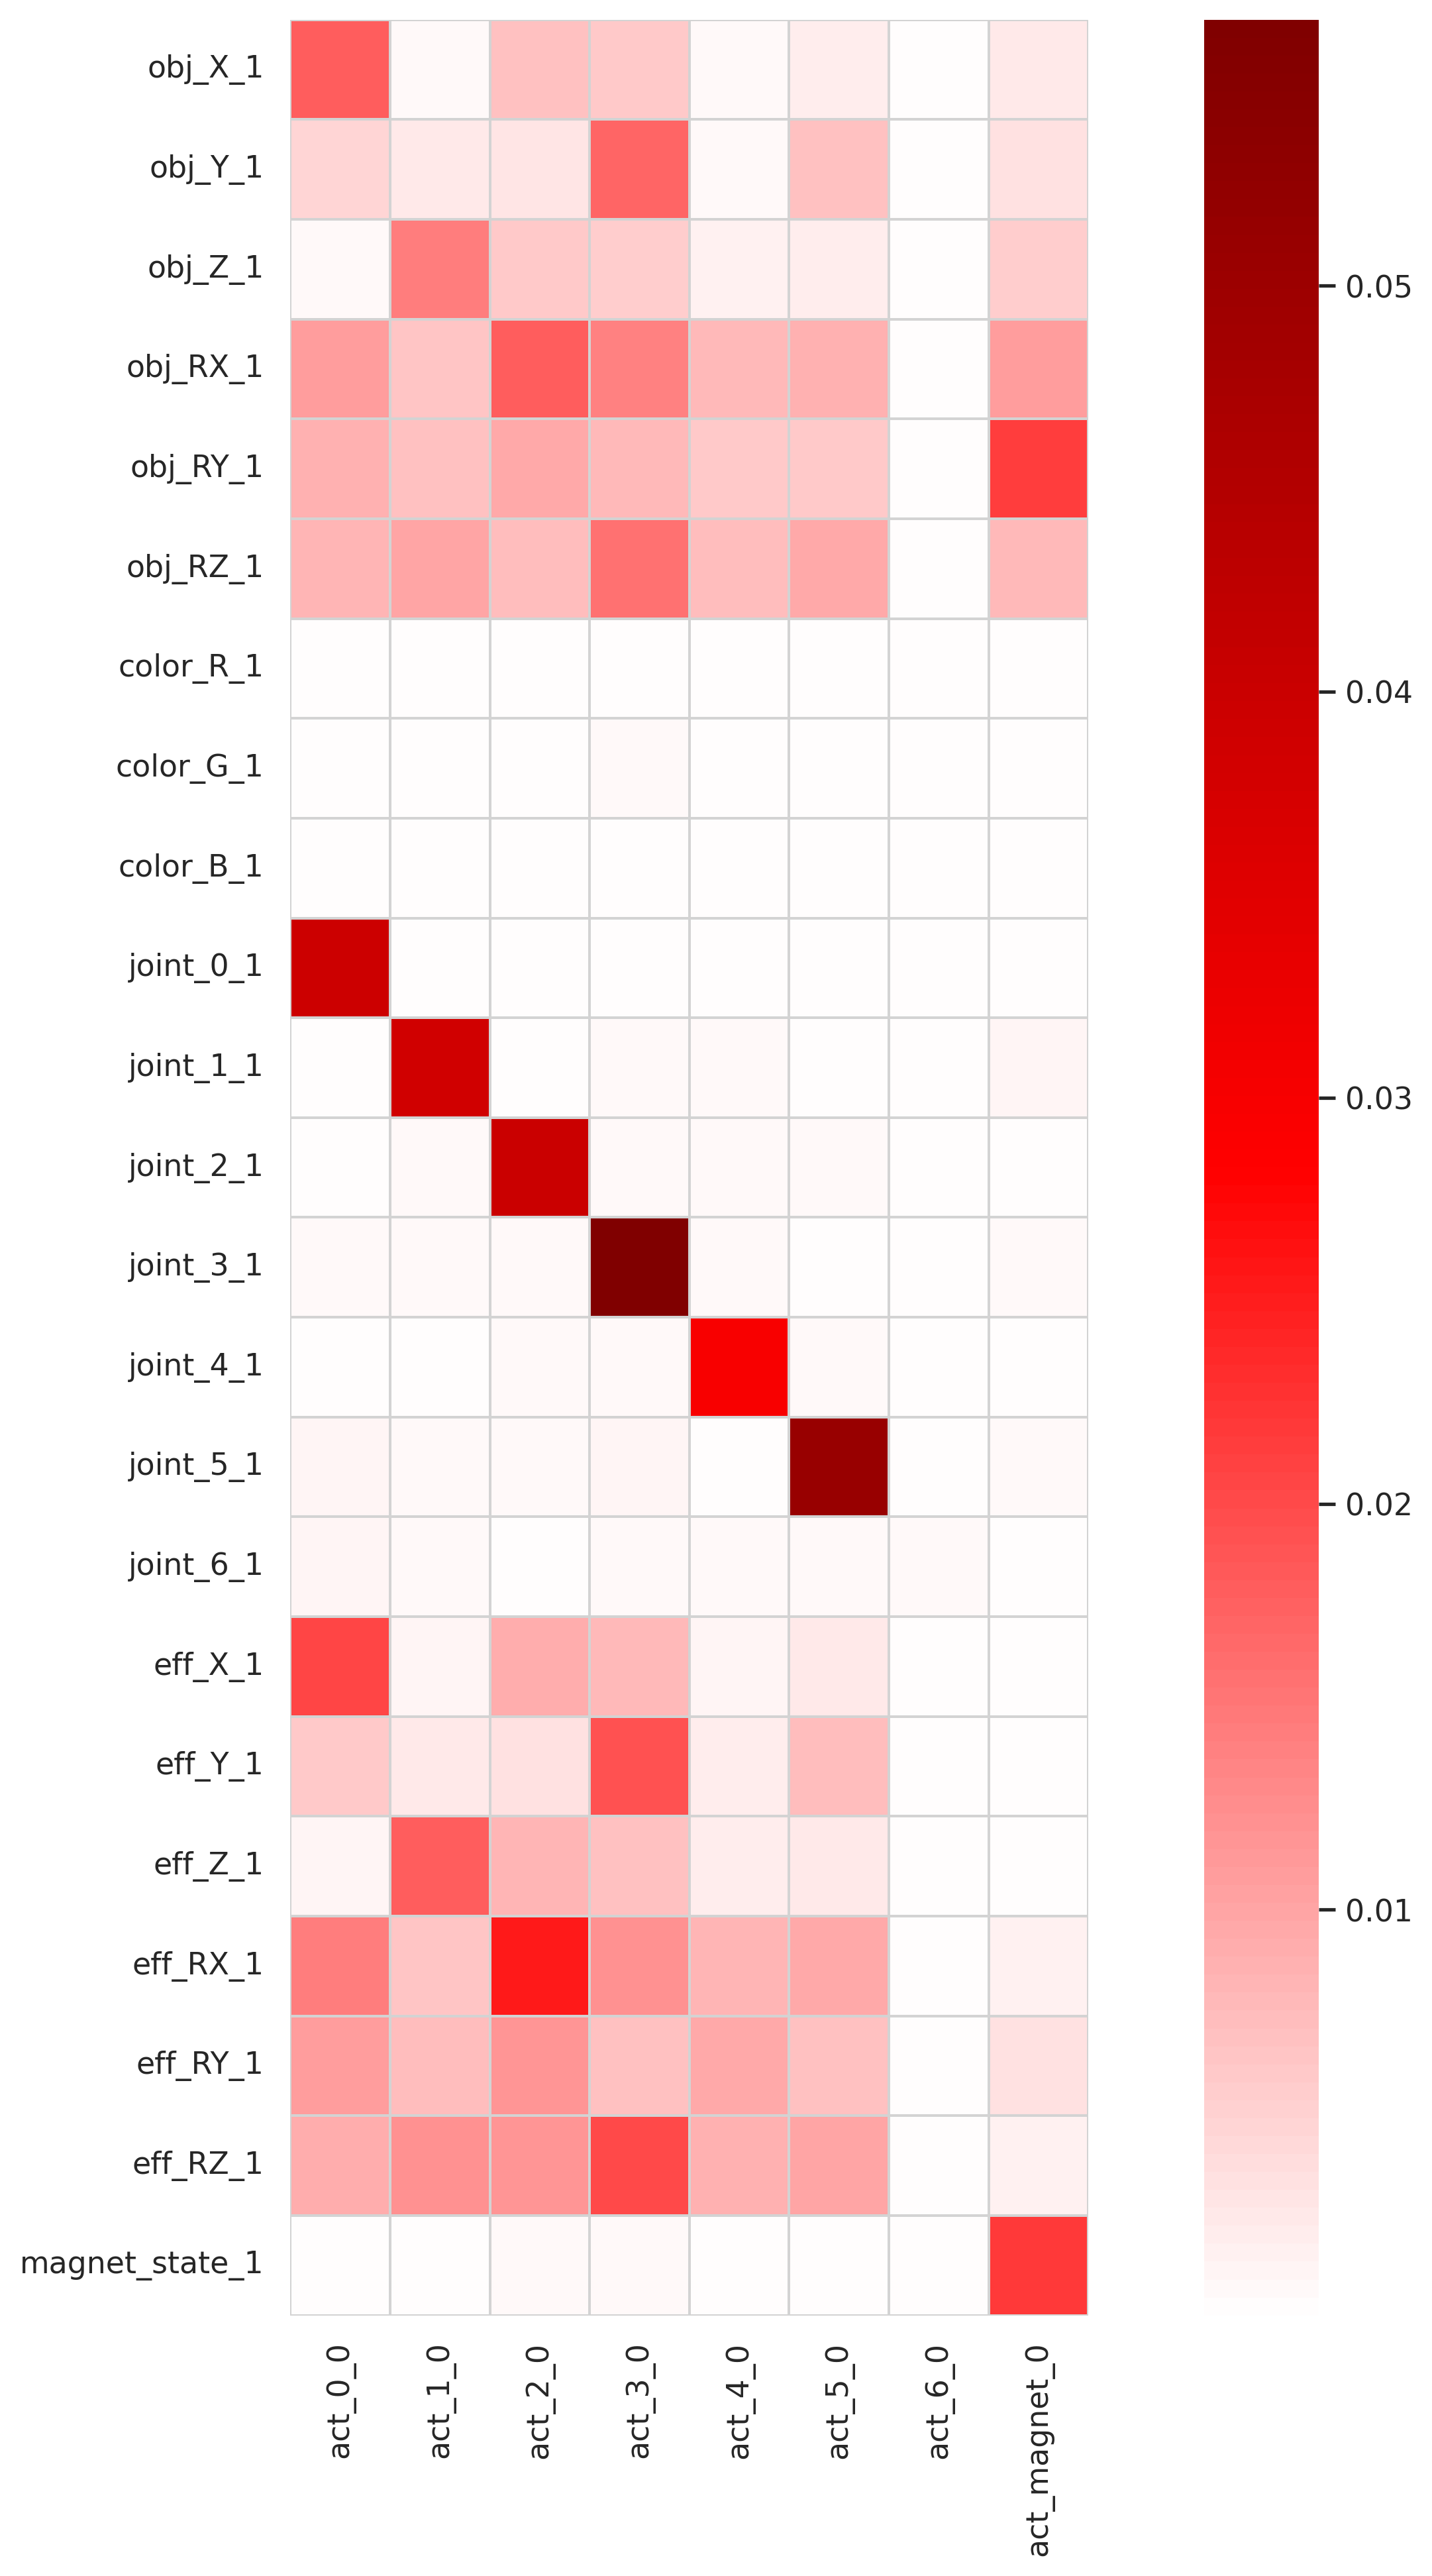

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    rc={
        'figure.figsize': (15, 15),
        'figure.dpi': 300
    }
)

ax = sns.heatmap(
    act_matrix,
    linewidths=0.5,
    linecolor='lightgray',
    center=0.0,
    square=True,
    xticklabels=[
        # 'obj_X_0', 'obj_Y_0', 'obj_Z_0', 'obj_RX_0', 'obj_RY_0', 'obj_RZ_0',
        # 'color_R_0', 'color_G_0', 'color_B_0',
        # 'joint_0_0', 'joint_1_0', 'joint_2_0', 'joint_3_0', 'joint_4_0', 'joint_5_0', 'joint_6_0',
        # 'eff_X_0', 'eff_Y_0', 'eff_Z_0', 'eff_RX_0', 'eff_RY_0', 'eff_RZ_0', 'magnet_state_0',
        'act_0_0', 'act_1_0', 'act_2_0', 'act_3_0', 'act_4_0', 'act_5_0', 'act_6_0', 'act_magnet_0'
    ],
    yticklabels=[
        'obj_X_1', 'obj_Y_1', 'obj_Z_1', 'obj_RX_1', 'obj_RY_1', 'obj_RZ_1',
        'color_R_1', 'color_G_1', 'color_B_1',
        'joint_0_1', 'joint_1_1', 'joint_2_1', 'joint_3_1', 'joint_4_1', 'joint_5_1', 'joint_6_1',
        'eff_X_1', 'eff_Y_1', 'eff_Z_1', 'eff_RX_1', 'eff_RY_1', 'eff_RZ_1', 'magnet_state_1'
    ],
    cmap='seismic'
)

plt.savefig('plots/kuka/magnetic/shap/deepshap_heatmap_act.png')

<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

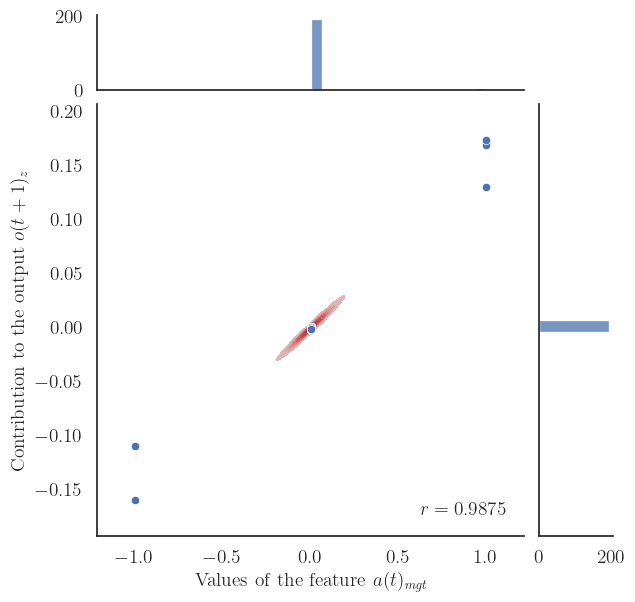

In [26]:
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

x_var = x_labels.index('act_magnet_0')
y_var = y_labels.index('obj_Z_1')

r, p = sp.stats.pearsonr(
    x=exp_file['test_data'][:, x_var],
    y=exp_file['exps'][:, x_var, y_var]
)

matplotlib.rcParams.update(matplotlib.rcParamsOrig)
plt.clf()

sns.set_theme(
    style='white',
    rc={
        'font.family': 'serif',
        'font.size': 14,
        'text.usetex': True,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        # 'axes.titlesize': 18,
        'svg.fonttype': 'none'
    }
)

plt.figure(figsize=(8, 8))

# sns.set_theme(
#     style='white',
#     rc={
#         'figure.figsize': (15, 15),
#         'figure.dpi': 300
#     }
# )
g = sns.jointplot(
    x=exp_file['test_data'][:, x_var],
    y=exp_file['exps'][:, x_var, y_var],
    # hue=exps2.values[:, 22, 10],
    # palette='seismic',
    # legend=False,
    # s=50
    kind='scatter',
    marginal_kws=dict(bins=30),
    marginal_ticks=True
)
g.plot_joint(sns.kdeplot, color='r', zorder=0, fill=True)
g.set_axis_labels(
    xlabel=f'Values of the feature {x_labels_tex[x_var]}',
    ylabel=f'Contribution to the output {y_labels_tex[y_var]}',
    fontsize=14
)
# plt.text(
#     0.1, 0.9,
#     f'$r = {r:.4f}$',
#     transform=g.fig.axes[0].transAxes, 
#     verticalalignment='top', 
#     horizontalalignment='left'
# )

g.fig.axes[0].add_artist(AnchoredText(f'$r = {r:.4f}$', 'lower right', frameon=False))

# plt.close()
plt.show()
# plt.savefig(f'plots/kuka/magnetic/shap/jointplots_icann/jointplot_pcc_{x_var}_{y_var}.svg', format='svg')
plt.close()

In [104]:
plt.close()

In [27]:
from tqdm import tqdm

matplotlib.rcParams.update(matplotlib.rcParamsOrig)
plt.clf()

sns.set_theme(
    style='white',
    rc={
        'font.family': 'serif',
        'font.size': 14,
        'text.usetex': True,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        # 'axes.titlesize': 18,
        'svg.fonttype': 'none'
    }
)

plots = []

for r, out_name in enumerate(tqdm(y_labels_tex)):
    row = []

    for c, in_name in enumerate(x_labels_tex[23:]):
        g = sns.jointplot(
            x=exp_file['test_data'][:, c + 23],
            y=exp_file['exps'][:, c + 23, r],
            kind='scatter',
            marginal_kws=dict(bins=30),
            marginal_ticks=True
        )

        g.plot_joint(sns.kdeplot, color='r', zorder=0, fill=True)
        g.set_axis_labels(
            xlabel=f'Values of the feature {in_name}',
            ylabel=f'SHAP contribution to the output {out_name}',
            fontsize=14    
        )

        coef_r, _ = sp.stats.pearsonr(
            x=exp_file['test_data'][:, c + 23],
            y=exp_file['exps'][:, c + 23, r]
        )

        g.fig.axes[0].add_artist(AnchoredText(f'$r = {coef_r:.4f}$', 'lower right', frameon=False))

        plt.close()
        row.append(g)

    plots.append(row)

100%|██████████| 23/23 [03:10<00:00,  8.27s/it]


In [28]:
import pickle

with open('../../plots/kuka/magnetic/shap/kuka_shap_plots_svg.pkl', 'wb') as f:
    pickle.dump(plots, f)

In [5]:
import pickle

with open('../../plots/kuka/magnetic/shap/kuka_shap_plots_svg.pkl', 'rb') as f:
    plots = pickle.load(f)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# plt.clf()

# sns.set_theme(
#     rc={
#         'font.family': 'serif',
#         'text.usetex': True,
#         'text.latex.preamble': r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{bm}',
#         'xtick.labelsize': 11,
#         'ytick.labelsize': 11,
#         'svg.fonttype': 'none'
#     }
# )

labels = {
    (9, 0): (r'a_0', r'\theta_0'),
    (0, 0): (r'a_0', r'o_x'),
    (8, 2): (r'a_2', r'o_B'),
    (2, 7): (r'a_{\mathit{mgnt}}', r'o_z')
}

for (r, c), (x_label, y_label) in labels.items():
    j = plots[r][c]
    j.set_axis_labels(
        xlabel=f'Values of feature ${x_label}$',
        ylabel=f'Contribution to output ${y_label}$'
    )

    j.fig.savefig(f'jointplot_pcc_{r}_{c}.svg', format='svg')

In [29]:
import matplotlib.pyplot as plt

for r, row in enumerate(plots):
    for c, plot in enumerate(row):
        plot.savefig(f'../../plots/kuka/magnetic/shap/shap_jointplot_svg/jointplot_pcc_{r}_{c}.svg')
        plt.close()

In [30]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import skunk

svg_dict = {
    f'sk{r}{c}': f'../../plots/kuka/magnetic/shap/shap_jointplot_svg/jointplot_pcc_{r}_{c}.svg'
    for r in range(len(y_labels))
    for c in range(8)
}

fig, axes = plt.subplots(nrows=len(y_labels), ncols=8, figsize=(64, 173), dpi=200)

for r in tqdm(range(len(y_labels))):
    for c in range(8):
        # img = plt.imread(f'../../plots/kuka/magnetic/shap/shap_jointplot_svg/jointplot_pcc_{r}_{c}.svg')
        # axes[r, c].imshow(img)
        axes[r, c].set_axis_off()
        skunk.connect(axes[r, c], f'sk{r}{c}')

plt.tight_layout()
svg = skunk.insert(svg_dict)

print('Saving...')
# plt.savefig('../../plots/kuka/magnetic/shap/shap_pcc_200dpi.svg')
# plt.close()
with open('../../plots/kuka/magnetic/shap/shap_pcc_200dpi.svg', 'w') as f:
    f.write(svg)

100%|██████████| 23/23 [00:00<00:00, 449.39it/s]


ValueError: Your given replacement object is not valid SVG (perhaps filepath was not valid?)

In [33]:
import skunk

svg = skunk.layout_svgs(
    svgs=[
        f'../../plots/kuka/magnetic/shap/shap_jointplot_svg/jointplot_pcc_{r}_{c}.svg'
        for r in range(len(y_labels))
        for c in range(8)
    ],
    shape=(len(y_labels), 8)
)

In [34]:
with open('../../plots/kuka/magnetic/shap/shap_pcc_200dpi.svg', 'w') as f:
    f.write(svg)

In [8]:
from tqdm import tqdm
import numpy as np
import scipy as sp

pearson = []
spearman = []
mean = []
abs_mean = []

for r, out_name in enumerate(tqdm(y_labels)):
    row_r = []
    row_rs = []
    row_mean = []
    row_abs_mean = []

    for c, in_name in enumerate(x_labels):
        coef_r, _ = sp.stats.pearsonr(
            x=exp_file['test_data'][:, c],
            y=exp_file['exps'][:, c, r]
        )

        coef_rs, _ = sp.stats.spearmanr(
            a=exp_file['test_data'][:, c],
            b=exp_file['exps'][:, c, r]
        )

        row_r.append(coef_r)
        row_rs.append(coef_rs)
        row_mean.append(np.mean(exp_file['exps'][:, c, r]))
        row_abs_mean.append(np.mean(np.abs(exp_file['exps'][:, c, r])))

    pearson.append(row_r)
    spearman.append(row_rs)
    mean.append(row_mean)
    abs_mean.append(row_abs_mean)

pearson = np.array(pearson)
spearman = np.array(spearman)
mean = np.array(mean)
abs_mean = np.array(abs_mean)


100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


In [13]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# sns.set_theme(
#     rc={
#         'figure.figsize': (8, 15),
#         'figure.dpi': 300
#     }
# )

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.clf()

sns.set_theme(
    rc={
        'font.family': 'serif',
        'text.usetex': True,
        'text.latex.preamble': r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{bm}',
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'svg.fonttype': 'none'
    }
)

plt.figure(figsize=(10, 10))

ax = sns.heatmap(
    abs_mean.T,
    linewidths=0.5,
    linecolor='lightgray',
    center=0.0,
    square=True,
    yticklabels=[
        r'$o(t)_x$', r'$o(t)_y$', r'$o(t)_z$', r'$o(t)_{\it rx}$', r'$o(t)_{\it ry}$', r'$o(t)_{\it rz}$',
        r'$o(t)_R$', r'$o(t)_G$', r'$o(t)_B$',

        r'$\theta(t)_0$', r'$\theta(t)_1$', r'$\theta(t)_2$', r'$\theta(t)_3$', r'$\theta(t)_4$', r'$\theta(t)_5$', r'$\theta(t)_6$',

        r'${\it ef}(t)_x$', r'${\it ef}(t)_y$', r'${\it ef}(t)_z$', r'${\it ef}(t)_{\it rx}$', r'${\it ef}(t)_{\it ry}$', r'${\it ef}(t)_{\it rz}$', r'${\it mgt}(t)$',
        r'$a(t)_0$', r'$a(t)_1$', r'$a(t)_2$', r'$a(t)_3$', r'$a(t)_4$', r'$a(t)_5$', r'$a(t)_6$', r'$a(t)_{\it mgt}$'
    ],
    xticklabels=[
        r'$o(t+1)_x$', r'$o(t+1)_y$', r'$o(t+1)_z$', r'$o(t+1)_{\it rx}$', r'$o(t+1)_{\it ry}$', r'$o(t+1)_{\it rz}$',
        r'$o(t+1)_R$', r'$o(t+1)_G$', r'$o(t+1)_B$',
        r'$\theta(t+1)_0$', r'$\theta(t+1)_1$', r'$\theta(t+1)_2$', r'$\theta(t+1)_3$', r'$\theta(t+1)_4$', r'$\theta(t+1)_5$', r'$\theta(t+1)_6$',
        r'${\it ef}(t+1)_x$', r'${\it ef}(t+1)_y$', r'${\it ef}(t+1)_z$', r'${\it ef}(t+1)_{\it rx}$', r'${\it ef}(t+1)_{\it ry}$', r'${\it ef}(t+1)_{\it rz}$', r'${\it mgt}(t+1)$',
    ],
    cmap='seismic',
    # cbar_kws={
    #     'location': 'bottom',
    #     'orientation': 'horizontal',
    #     'pad': 0.25
    # }
)

plt.savefig('../../plots/kuka/magnetic/shap/deepshap_heatmap.svg', format='svg')
# plt.show()

In [8]:
exp = explainer(X=shap.sample(X_fwd_shap_test, 1))

  0%|          | 0/1 [00:00<?, ?it/s]

    1/13163 [..............................] - ETA: 14:20

2024-03-18 18:42:44.316469: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48859200 exceeds 10% of free system memory.


13163/13163 [==============================] - 39s 3ms/step


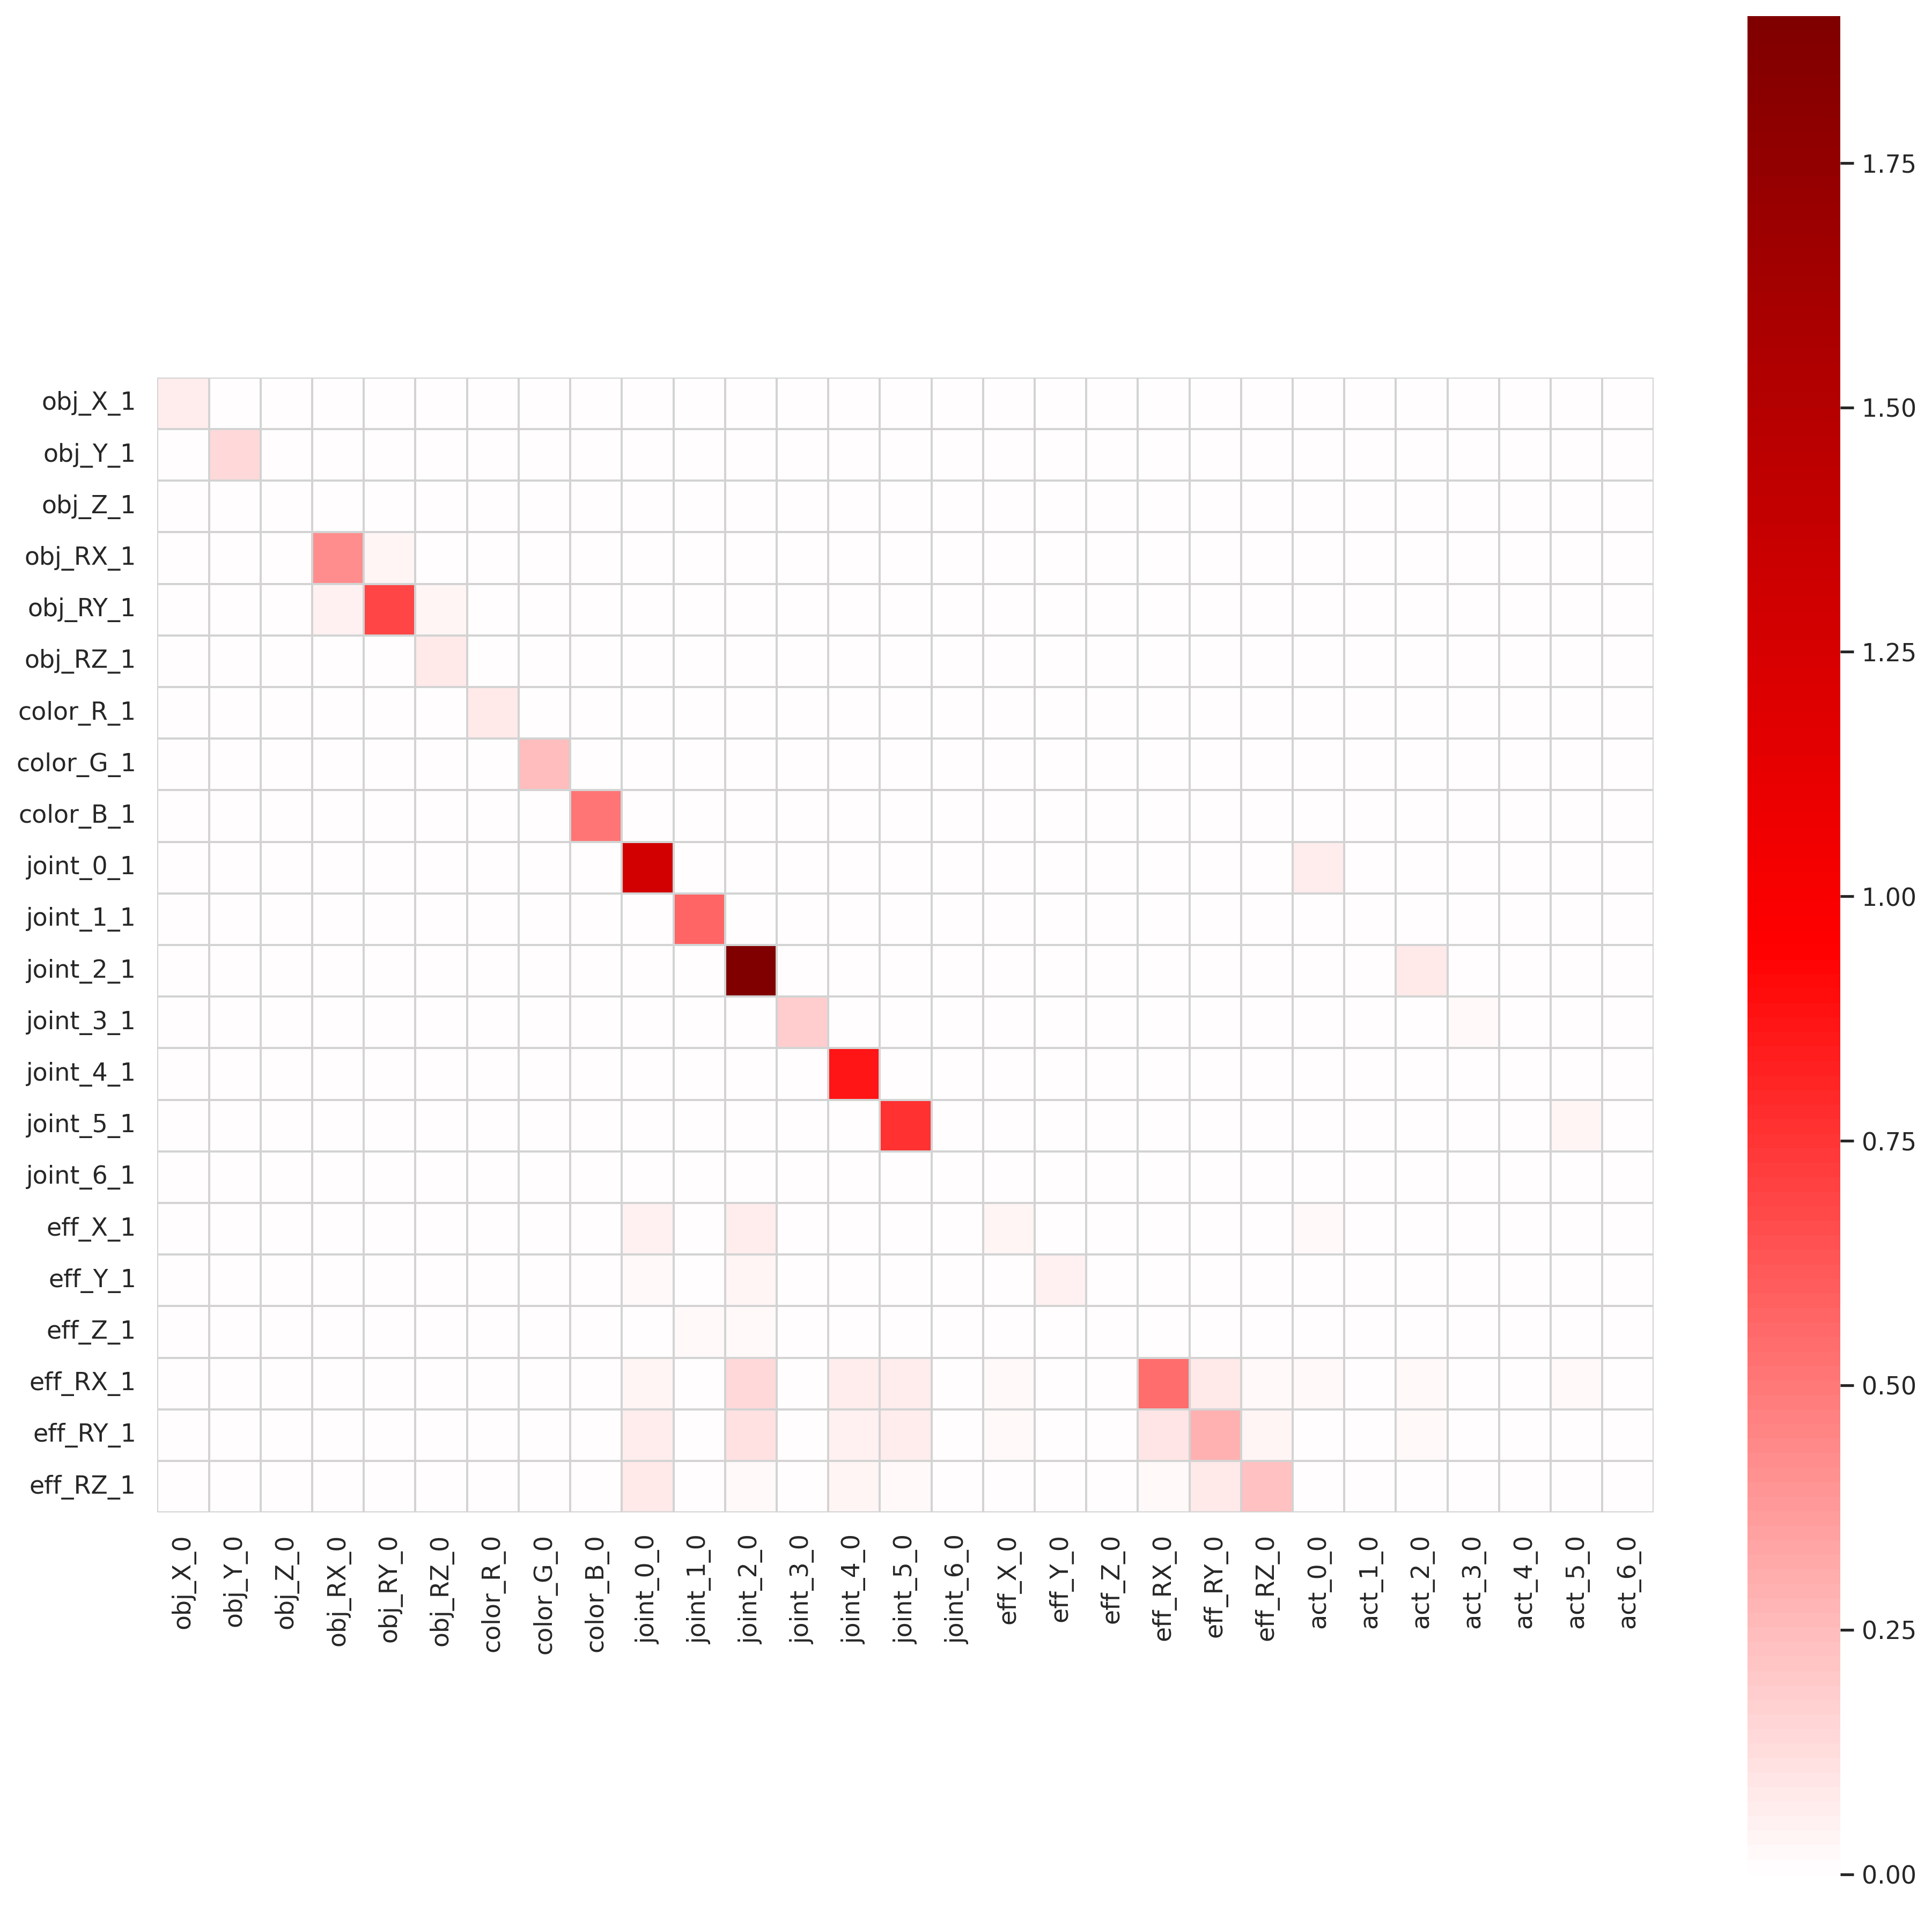

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    rc={
        'figure.figsize': (15, 15),
        'figure.dpi': 300
    }
)

ax = sns.heatmap(
    exp.abs.values[0].T,
    linewidths=0.5,
    linecolor='lightgray',
    center=0.0,
    square=True,
    xticklabels=[
        'obj_X_0', 'obj_Y_0', 'obj_Z_0', 'obj_RX_0', 'obj_RY_0', 'obj_RZ_0',
        'color_R_0', 'color_G_0', 'color_B_0',
        'joint_0_0', 'joint_1_0', 'joint_2_0', 'joint_3_0', 'joint_4_0', 'joint_5_0', 'joint_6_0',
        'eff_X_0', 'eff_Y_0', 'eff_Z_0', 'eff_RX_0', 'eff_RY_0', 'eff_RZ_0',
        'act_0_0', 'act_1_0', 'act_2_0', 'act_3_0', 'act_4_0', 'act_5_0', 'act_6_0'
    ],
    yticklabels=[
        'obj_X_1', 'obj_Y_1', 'obj_Z_1', 'obj_RX_1', 'obj_RY_1', 'obj_RZ_1',
        'color_R_1', 'color_G_1', 'color_B_1',
        'joint_0_1', 'joint_1_1', 'joint_2_1', 'joint_3_1', 'joint_4_1', 'joint_5_1', 'joint_6_1',
        'eff_X_1', 'eff_Y_1', 'eff_Z_1', 'eff_RX_1', 'eff_RY_1', 'eff_RZ_1'
    ],
    cmap='seismic'
)

plt.savefig('shap_abs_single.png')